In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import torch
from matplotlib import pyplot as plt
import seaborn as sns

from ex2mcmc.samplers import flex2mcmc, ex2mcmc
from ex2mcmc.models.rnvp_minimal import MinimalRNVP
from ex2mcmc.models.rnvp import RNVP
from ex2mcmc.utils.general_utils import IMGS_DIR, random_seed

from utils import ema, plot_result
from ex2mcmc.pyro_samplers import NUTS, HMC

sns.set_theme('talk', style="white")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
N_CHAINS = 1
N_SAMPLES = 1000
BURN_IN = 100

PROJ_DIM1 = -2
PROJ_DIM2 = -1

In [8]:
class Banana(object):
    """
    """
    def __init__(self, dim: int, b: float, sigma: float):
        #self.q = q
        self.b = b
        self.sigma = sigma
        self._dim = dim
        #self.normal_even = Normal(1, 1)
        #self.normal_odd = Normal(0, q)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        even = np.arange(0, x.shape[-1], 2)
        odd = np.arange(1, x.shape[-1], 2)
        ll = -0.5*(x[..., odd] - self.b*x[..., even]**2 + (self.sigma**2)*self.b)**2 - ((x[..., even])**2)/(2*self.sigma**2)
        return ll.sum(-1)

    def plot_2d_countour(self, ax):
        x = np.linspace(-15, 15, 100)
        y = np.linspace(-5, 5, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=5,
                   alpha=1., colors='midnightblue', linewidths=1)

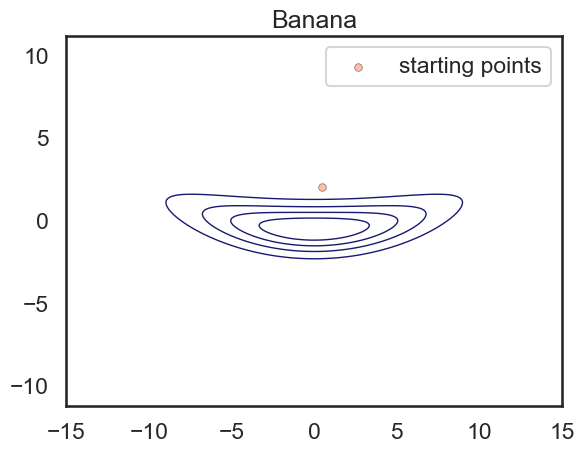

In [9]:
sigma_b = 5.0
banana_b = 0.02
dim = 100

banana = Banana(dim, banana_b, sigma_b)
ax = plt.subplot()
banana.plot_2d_countour(ax)

start_banana = torch.randn((N_CHAINS, banana.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_banana[:, proj_slice].T, s=30, c='coral', edgecolors='black', linewidth=0.5, alpha=0.5, marker='o', label='starting points')
plt.title('Banana')
plt.legend()
plt.axis('equal')
plt.show()

In [5]:
step_size = 0.1

random_seed(42)

chains = NUTS(start_banana.to(device), banana, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:13, 81.66it/s, step size=2.78e-01, acc. prob=0.853]


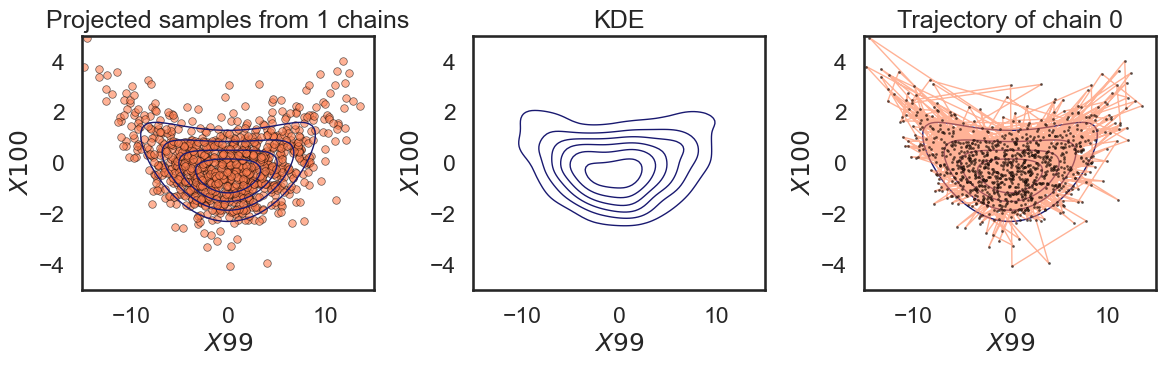

In [10]:
plot_result(chains.cpu(), banana, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)
# plt.savefig(Path(IMGS_DIR, 'nuts_banana.png'))

Text(0.5, 1.0, 'NUTS samples')

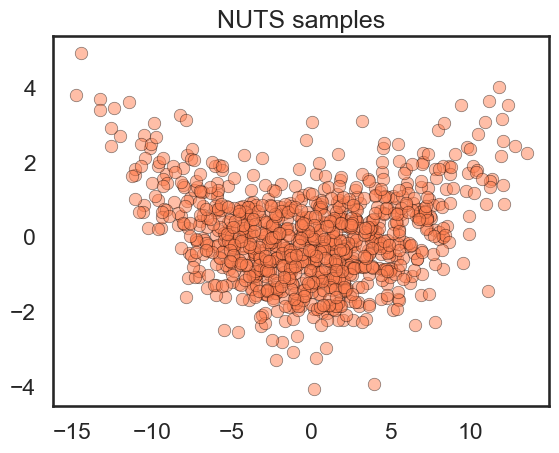

In [11]:
chains = chains.cpu()
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], c='coral', edgecolors='black', linewidth=0.5, alpha=0.5, marker='o',)
plt.title(r'NUTS samples')

In [12]:
step_size = 1.0
target_acceptance = 0.67
n_particles = 200
n_mala_steps = 5
train_steps = 500
batch_size = 100
prior_scale = 1
backward_kl_weight = 0.1
forward_kl_weight = 1 - backward_kl_weight

proposal = RNVP(num_blocks=4, dim=dim, device=device, scale=prior_scale)
opt = torch.optim.Adam(proposal.parameters(), 5e-4)
proposal.optim = opt
proposal.train()
proposal.scheduler = torch.optim.lr_scheduler.LambdaLR(
    opt, lambda it: int(it < train_steps)
)

random_seed(42)

# train
flex2mcmc(
    proposal.prior.sample((batch_size,)),
    banana, 
    proposal, 
    1,
    train_steps,
    step_size=step_size, 
    n_particles=10,
    n_mala_steps=n_mala_steps,
    forward_kl_weight=forward_kl_weight,
    backward_kl_weight=backward_kl_weight,
    target_acceptance=target_acceptance,
    verbose=True)

proposal.eval();

KL forw 226.436,                      KL back -165.843 : 100%|██████████| 501/501 [00:33<00:00, 14.83it/s]


Text(0.5, 1.0, 'NF samples')

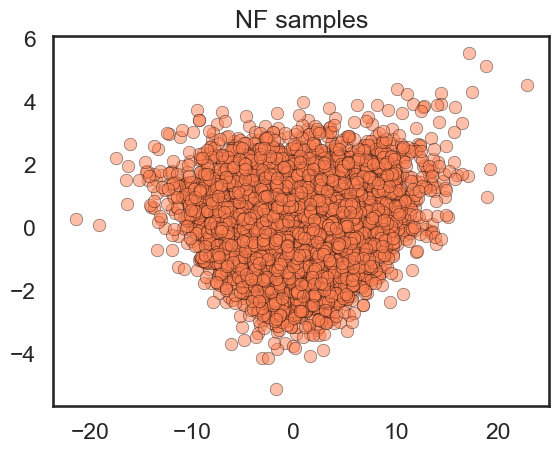

In [13]:
sample = proposal.sample((10000,)).detach().cpu()
plt.scatter(sample.view(-1, dim)[:, PROJ_DIM1], sample.view(-1, dim)[:, PROJ_DIM2], c='coral', edgecolors='black', linewidth=0.5, alpha=0.5, marker='o')
plt.title('NF samples')

In [14]:
# sample
step_size = 0.1

chains, meta = flex2mcmc(
    start_banana.to(device), 
    banana, 
    proposal, 
    N_SAMPLES,
    BURN_IN,
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    target_acceptance=target_acceptance,
    verbose=True)
chains = chains.detach().cpu()

100%|██████████| 1100/1100 [00:20<00:00, 54.53it/s]


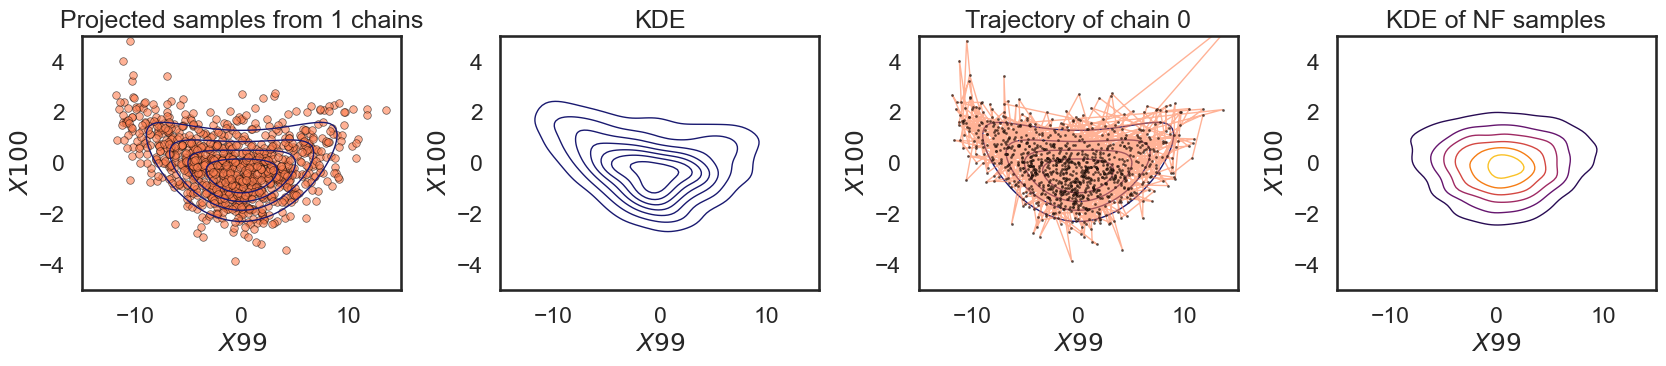

In [15]:
plot_result(chains.cpu(), banana, proposal, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)
# plt.savefig(Path(IMGS_DIR, 'flex_banana.png'))

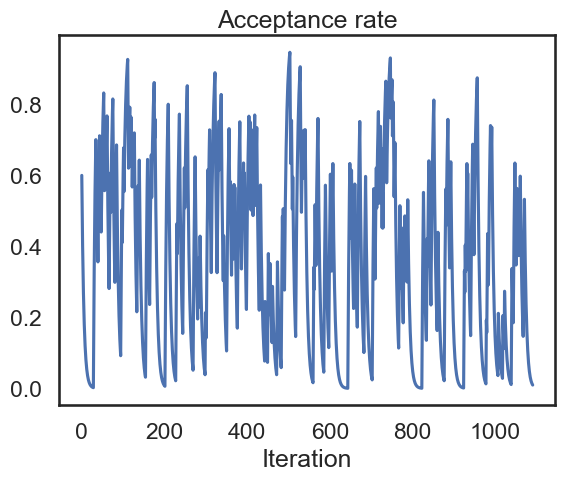

In [16]:
plt.plot(ema(meta['sir_accept'], 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
plt.show()

Text(0.5, 1.0, 'FlEx$^2$MCM samples')

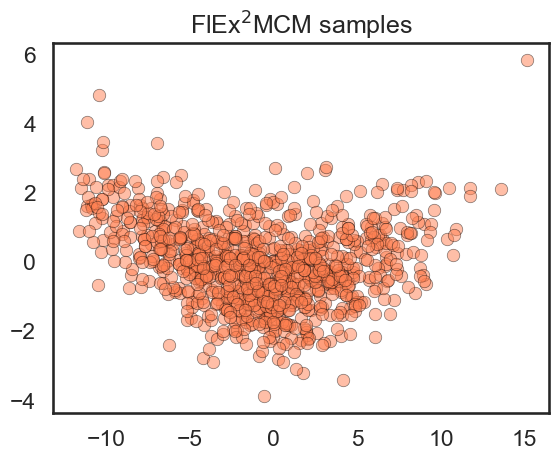

In [17]:
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], c='coral', edgecolors='black', linewidth=0.5, alpha=0.5, marker='o')
plt.title(r'FlEx$^2$MCM samples')